# Prediction of reference annotations in CC Certificates

This notebook:
- loads dataframe of a dataset with `(dgst, cert_id, sentences, label)`
- Trains a model to classify the sentences related to certificate reference to their common sentiment (meaning of reference)

In [1]:
# When on Aura, it is important to first set CUDA_VISIBLE_DEVICES environment variable directly from notebook
# For available GPUs, see https://www.fi.muni.cz/tech/unix/aura.html.cs

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a5459e6a-b26d-5985-874c-528458a7728b"
print(os.getenv("CUDA_VISIBLE_DEVICES"))

import pandas as pd
from sec_certs.utils.nlp import prec_recall_metric
from pathlib import Path
from sec_certs.model import ReferenceSegmentExtractor, ReferenceAnnotator, ReferenceAnnotatorTrainer
from sec_certs.dataset import CCDataset
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

REPO_ROOT = Path("../../../").resolve()

MIG-a5459e6a-b26d-5985-874c-528458a7728b


In [2]:
# Load df or fully process it with ReferenceSegmentExtractor
df = pd.read_csv(REPO_ROOT / "datasets/reference_classification_dataset.csv")

# dset = CCDataset.from_json(REPO_ROOT / "datasets/cc/cc_dataset.json")
# df = ReferenceSegmentExtractor().prepare_df_from_cc_certs([x for x in dset])

In [3]:
# init trainer, train and evaluate
trainer = ReferenceAnnotatorTrainer.from_df(df, prec_recall_metric, "transformer", "training")
trainer.train()
trainer.evaluate()
clf = trainer.clf

# # Serialize and de-serialize the classifier
trainer.clf.save_pretrained(REPO_ROOT / "datasets/cc/reference_annotator")
clf = ReferenceAnnotator.from_pretrained(REPO_ROOT / "datasets/cc/reference_annotator")

config.json not found in HuggingFace Hub
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 17040
  Num epochs = 1
  Total optimization steps = 1065
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1065 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


Internal evaluation (of model working on individual segments)
{'precision': 0.13023255813953488, 'recall': 0.13023255813953488}
Actual evaluation after ensemble soft voting
{'precision': 0.6923076923076923, 'recall': 0.6923076923076923}


In [4]:
# Take a look at misclassified instances
df_train = clf.predict_df(trainer._train_dataset)
df_eval = clf.predict_df(trainer._eval_dataset)

In [5]:
df_train.loc[~df_train.correct].head()

,dgst,referenced_cert_id,label,segments,y_proba,y_pred,correct
756,ab3af998dff7a2ef,ANSSI-CC-2017/47,COMPONENT_USED,[ANSSI-CC-2017/47 le 5 septembre 2017.\n],"[0.20372918003354076, 0.1846070821627411, 0.15...",ON_PLATFORM,False


In [6]:
df_eval.loc[~df_eval.correct].head()

,dgst,referenced_cert_id,label,segments,y_proba,y_pred,correct
13,031667f4e242da61,CCEVS-VR-07-0054,ON_PLATFORM,[[CCEVS-VR-07-0054] Common Criteria Evaluation...,"[0.08122691074400883, 0.593865460042782, 0.081...",COMPONENT_USED,False
91,0fe8df0e85116b61,ANSSI-CC-2010/33,COMPONENT_SHARED,[CC IDeal Citiz (sur\ncomposants SB23YR80B et ...,"[0.12980833111443874, 0.3509582926631846, 0.12...",COMPONENT_USED,False
118,16abf8ee0697e64f,ANSSI-CC-2014/61,COMPONENT_SHARED,[sous la référence [ANSSI-CC-2014/61].\n],"[0.315498585227761, 0.13724939680170528, 0.136...",ON_PLATFORM,False
183,22388445fe620ac0,ANSSI-CC-2014/20,EVALUATION_REUSED,[[ANSSI-CC-\n2014/20]\nRapport de certificatio...,"[0.24171578677684094, 0.30556432298553843, 0.1...",COMPONENT_USED,False
198,24de96ea505af909,ANSSI-CC-2021/29,ON_PLATFORM,[[M01-PLF] Rapport de maintenance ANSSI-CC-202...,"[0.040365307026386466, 0.7341872530469308, 0.0...",COMPONENT_USED,False


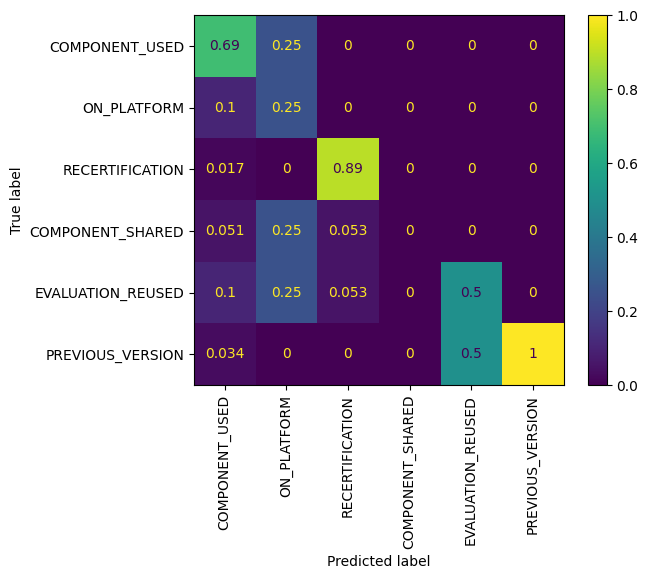

In [7]:
ConfusionMatrixDisplay.from_predictions(df_eval.label, df_eval.y_pred, labels=df_eval.label.unique(), display_labels=df_eval.label.unique(), xticks_rotation=90, normalize="pred")

In [8]:
df_eval.label.value_counts()

COMPONENT_USED       43
RECERTIFICATION      18
EVALUATION_REUSED    11
ON_PLATFORM           8
COMPONENT_SHARED      6
PREVIOUS_VERSION      5
Name: label, dtype: int64

In [9]:
# Experiments with ensemble for soft-voting on top of the base model.
# But this is dump, since the ensemble is position-specific w.r.t. sequence, while the individual sentences are not.
from sklearn.ensemble import RandomForestClassifier

df_train["y_proba_base"] = df_train.segments.map(trainer._model.predict_proba).map(lambda x: x.flatten())
feat_len = df_train["y_proba_base"].map(len).max()
df_train["rf_feature_vector"] = df_train.y_proba_base.map(lambda x: np.pad(x, pad_width=(0, feat_len - len(x))))

df_eval["y_proba_base"] = df_eval.segments.map(trainer._model.predict_proba).map(lambda x: x.flatten())
df_eval["rf_feature_vector"] = df_eval.y_proba_base.map(lambda x: np.pad(x, pad_width=(0, feat_len - len(x))))

clf = RandomForestClassifier()
clf = clf.fit(df_train.rf_feature_vector.tolist(), df_train.label)

df_train["rf_predict"] = clf.predict(df_train.rf_feature_vector.tolist())
df_eval["rf_predict"] = clf.predict(df_eval.rf_feature_vector.tolist())